# Exploring the Data from the students Dataset

In [75]:
# Import libraries that are necessary immediately, will import the remaining later 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# import the csv as a DataFrame
df = pd.read_csv('StudentScoresData_Expanded.csv', index_col=0)

In [77]:
# inspect the shape of the DataFrame
df.shape

(30641, 14)

The DataFrame has 14 columns and 30641 rows

In [78]:
# inspect basic info about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30641 entries, 0 to 960
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.5+ MB


Most of the columns in this DataFrame have an object type and are strings. There are three integer columns: MathScore, ReadingScore and WritingScore. NrSiblings is has a float dtype.

In [79]:
# Inspect the first few rows of the DataFrame
df.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


In [80]:
# Renaming the columns in snake case for easier access and simplicity
col_mapping = {
    'Gender': 'gender',
    'EthnicGroup': 'ethnicity',
    'ParentEduc': 'parental_education',
    'LunchType' : 'lunch_type',
    'TestPrep' : 'test_prep',
    'ParentMaritalStatus' : 'parent_marital_status',
    'PracticeSport' : 'practice_sports',
    'IsFirstChild' : 'first_child',
    'NrSiblings' : 'num_siblings',
    'TransportMeans' : 'transport_means',
    'WklyStudyHours' : 'weekly_study_hours',
    'MathScore' : 'math_score',
    'ReadingScore' : 'reading_score',
    'WritingScore' : 'writing_score'
}
df = df.rename(columns=col_mapping)

# Check columns after renaming
df.columns

Index(['gender', 'ethnicity', 'parental_education', 'lunch_type', 'test_prep',
       'parent_marital_status', 'practice_sports', 'first_child',
       'num_siblings', 'transport_means', 'weekly_study_hours', 'math_score',
       'reading_score', 'writing_score'],
      dtype='object')

In [81]:
nan_rows = df.isnull().any(axis=1).sum()
print(f"Rows with at least one NaN: {nan_rows} ({nan_rows/len(df)*100:.1f}%)")

Rows with at least one NaN: 11398 (37.2%)


37.2% of the rows have at least one NaN value, and this many rows cannot be discarded outright. Further analysis is required to handle null values. 

In [82]:
# check which columns have the most NaN values
df.isnull().sum().sort_values(ascending=False)

transport_means          3134
parental_education       1845
ethnicity                1840
test_prep                1830
num_siblings             1572
parent_marital_status    1190
weekly_study_hours        955
first_child               904
practice_sports           631
gender                      0
lunch_type                  0
math_score                  0
reading_score               0
writing_score               0
dtype: int64

`transport_means` has the highest number of NaN counts, followed by `parental_education`, `ethnicity`, `test_prep`, `num_siblings`, `parent_marital_status`, `weekly_study_hours`, `first_child` and `practice_sports` in that order. 

The NaN values in `transport_means`, `parental_education`, `ethnicity`, `parent_martial_status`,`practice_sports`, `test_prep` and `first_child` can be imputed as unknown. This will work well for all models since it will become it's own category in one hot encoding. 

`num_siblings` is a float64 column and NaN values will be replaced with median values. The median preserves central tendency without outlier sensitivity. The median is better than the mean for resistance to outliers. There is minimal-bias for tree-based models since they split on medians anyway (median is the cut point between two different branches). Linear regression models will have predictions more concentrated around the mean, resulting in slight downward variance reduction.

In [83]:
df['weekly_study_hours'].value_counts()

weekly_study_hours
5 - 10    16246
< 5        8238
> 10       5202
Name: count, dtype: int64

While `weekly_study_hours` is has an object dtype, it is clearly split into buckets and can be treated as ordinal categorical. It can be imputed as unknown for now, and will be handled later if there is a need to split it into numeric buckets. 

In [84]:
# imputing all the NaN values in the DataFrame with unkwnowns for categorical and median for numerical
cols_to_impute = ['transport_means', 'parental_education', 'ethnicity', 'parent_marital_status', 'weekly_study_hours', 'practice_sports',
                  'test_prep', 'first_child']
for col in cols_to_impute:
    df[col] = df[col].fillna('unknown')

df['num_siblings'] = df['num_siblings'].fillna(df['num_siblings'].median())

In [85]:
print("\nPost-impute shape:", df.shape)
print("Remaining NaNs:\n", df.isnull().sum().sum())


Post-impute shape: (30641, 14)
Remaining NaNs:
 0


The entire dataset was retained via semantic imputation ('unknown' for categorical variables and median for siblings). This maximizes the statistical power of the dataset while transparently handling missingness. 


The DataFrame has been organized by changing column names and handling null values. We can now proceed with inspecting basic statistics and distributions of the student scores. 

In [86]:
score_stats_cols = ['math_score', 'reading_score', 'writing_score']
score_stats = df[score_stats_cols].describe()
print(score_stats)

         math_score  reading_score  writing_score
count  30641.000000   30641.000000   30641.000000
mean      66.558402      69.377533      68.418622
std       15.361616      14.758952      15.443525
min        0.000000      10.000000       4.000000
25%       56.000000      59.000000      58.000000
50%       67.000000      70.000000      69.000000
75%       78.000000      80.000000      79.000000
max      100.000000     100.000000     100.000000


The differences in the basic descriptive statistics can be clearly seen above. 
- The means range from 66.55 to 69.37 across all three scores and can be considered to be fairly close
- The standard deviations range from 14.75 to 15.44
- The minimum score in math is 0, 10 in reading and 4 in writing
- The lower quartile value is at 56 for math, 59 for reading and 58 for writing
- The median is 67 for math, 70 for reading and 69 for writing
- The upper quartile is 78 for math, 80 for reading and 79 for writing
- The max is 100 for all three scores

It is clear that the mean, median and quartiles for math tend to range 1-2 points lower than both reading and writing.

In [87]:
# creating a column for the average score of all three subjects
df['avg_score'] = df[['math_score', 'reading_score', 'writing_score']].mean(axis=1)
df['avg_score'].describe()

count    30641.000000
mean        68.118186
std         14.454327
min          9.000000
25%         58.333333
50%         68.333333
75%         78.666667
max        100.000000
Name: avg_score, dtype: float64

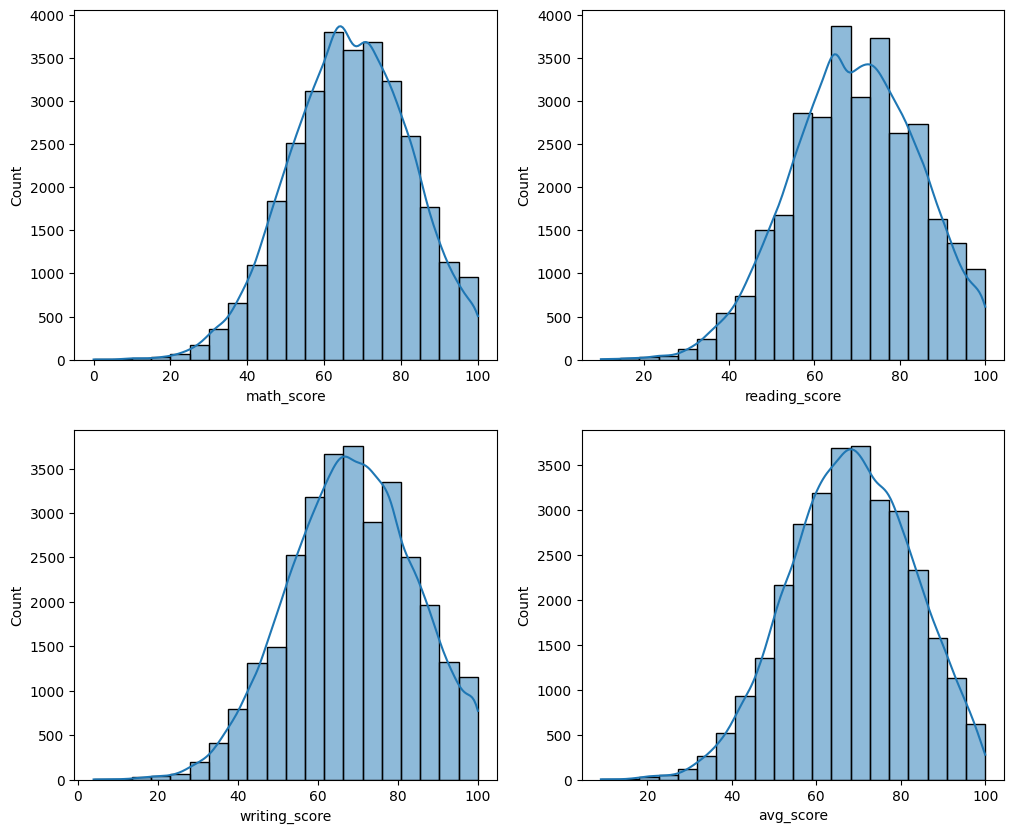

In [88]:
# creating a side-by-side histogram to compare the distributions of math, reading, writing and average scores
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(data=df, x='math_score', bins=20, ax=axes[0, 0], kde=True)
sns.histplot(data=df, x='reading_score', bins=20, ax=axes[0, 1], kde=True)
sns.histplot(data=df, x='writing_score', bins=20, ax=axes[1, 0], kde=True)
sns.histplot(data=df, x='avg_score', bins=20, ax=axes[1, 1], kde=True)
plt.show()

As seen in the histograms above, all three core scores have left-skewed distributions, with the peaks just between 60 and 70. This is expected based on the descriptive statistics drawn from these columns earlier. The average of all three scores follows a similar distribution, but it smoother due to averaging all three scores. 

Now, I'll look at value counts for categorical variables.
'transport_means', 'parental_education', 'ethnicity', 'parent_marital_status', 'weekly_study_hours', 'practice_sports',
                  'test_prep', 'first_child'

In [89]:
df['transport_means'].value_counts()

transport_means
school_bus    16145
private       11362
unknown        3134
Name: count, dtype: int64

16145 students take the school bus, while 11362 rely on public transportation. We do not know the method of transportation for 3134 students. 

In [90]:
df['parental_education'].value_counts()

parental_education
some college          6633
high school           5687
associate's degree    5550
some high school      5517
bachelor's degree     3386
master's degree       2023
unknown               1845
Name: count, dtype: int64

Over 6000 students have parents with some college education. Roughly 5500 have parents with education levels at high school, associates degrees, or some level of high school. 3386 habe parents with bachelors and 1845 have parents with masters. The education level of 1845 students is unknown. Roughly 5000 students have parents with some level of college education. 

In [91]:
df['ethnicity'].value_counts()

ethnicity
group C    9212
group D    7503
group B    5826
group E    4041
group A    2219
unknown    1840
Name: count, dtype: int64

Ethnicity group c has the most students (9212), followed by D (7503), B (5286), E (4041) and then A (2219). The ethnic group for 1840 students is unknown. There is a good mix of ethnic groups of students in the available data. 

In [92]:
df['parent_marital_status'].value_counts()

parent_marital_status
married     16844
single       7097
divorced     4919
unknown      1190
widowed       591
Name: count, dtype: int64

16844 students have married parents, 7097 students have single parents, 4919 have divorced parents and 591 have widowed parents. The marital status for 1190 students is unknown. More than half the students have married parents. 

In [93]:
df['weekly_study_hours'].value_counts()

weekly_study_hours
5 - 10     16246
< 5         8238
> 10        5202
unknown      955
Name: count, dtype: int64

Most students, 16246 to be exact, study 5-10 hours a week. 8238 students study less than 5 hours a week, while 5202 study more than 10 hours a week. The study data for 955 students is unknown. A majority of students study up to 10 hours a week. 

In [94]:
df['practice_sports'].value_counts()

practice_sports
sometimes    15213
regularly    10793
never         4004
unknown        631
Name: count, dtype: int64

15213 students play sports sometimes, 10793 play sports regularly, 4004 students never play sports and the data for 631 students is unkown. It can be seen that most students engage in some kind of sports activity. 

In [95]:
df['test_prep'].value_counts()

test_prep
none         18856
completed     9955
unknown       1830
Name: count, dtype: int64

Nearly two thirds of the students have not completed test prep, while a third have. Data for 1830 students is unknown. 

In [96]:
df['first_child'].value_counts()

first_child
yes        19082
no         10655
unknown      904
Name: count, dtype: int64

Nearly two thirds of the children are the first child, while a third are not. We do not have data for 904 students. 

In [97]:
df['lunch_type'].value_counts()

lunch_type
standard        19905
free/reduced    10736
Name: count, dtype: int64

Roughly 20000 students have standard lunches, while about 10000 have reduced or free lunches. 

In [98]:
df['num_siblings'].value_counts()

num_siblings
2.0    8362
1.0    8217
3.0    6123
0.0    3085
4.0    2941
5.0    1320
6.0     302
7.0     291
Name: count, dtype: int64

A majority of students have one, two or no siblings. There are a few outliers with 5 or more siblings. The unknown data for this column was taken as the median of the column, so that is something to keep in mind when analyzing this column in the future. 

#### **Now that the data has been cleaned and a basic understanding of the descriptive statistics has been established, the relationship between scores and certain categorical variables can be explored.**

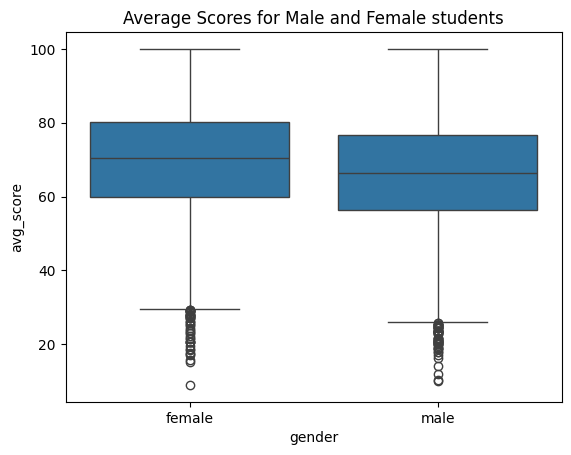

In [99]:
sns.boxplot(data=df, x='gender', y='avg_score')
plt.title('Average Scores for Male and Female students')
plt.show()

As seen from the boxplot above, female students tend to have slightly higher average scores than male students. 

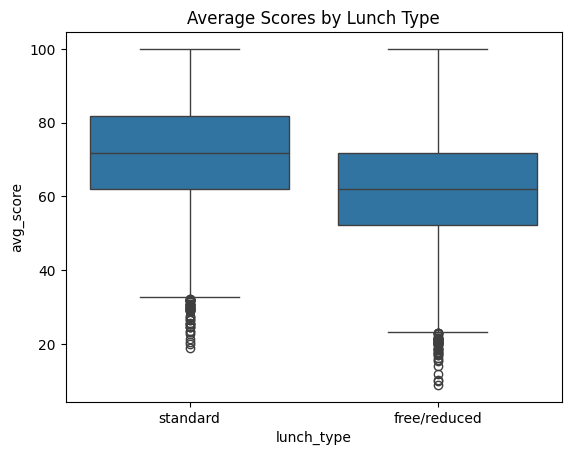

In [100]:
sns.boxplot(data=df, x='lunch_type', y='avg_score')
plt.title('Average Scores by Lunch Type')
plt.show()

The boxplot above aims to see the differences in average scores by the students type of lunch. There is a noticeable difference between students who receive a standard lunch vs those who receive a free/reduced lunch. The lunch_type metric could be used as an indicator of socioeconomic status.

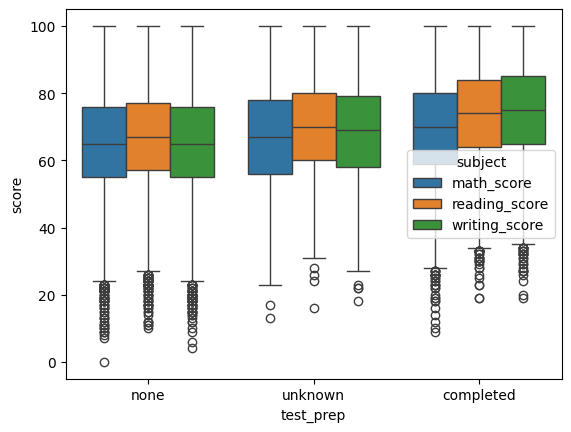

In [101]:
# checking to see if test prep has any effect on the scores
df_melt = pd.melt(df, id_vars=['test_prep'], value_vars=['math_score', 'reading_score', 'writing_score'], var_name='subject', value_name='score')
sns.boxplot(data=df_melt, x='test_prep', y='score', hue='subject')
plt.show()

As seen from the plot above, students who have completed their test prep tend to score higher across all three subjects, with larger differences in reading and writing scores. Completing test prep has the strongest effect on writing, followed by reading. 

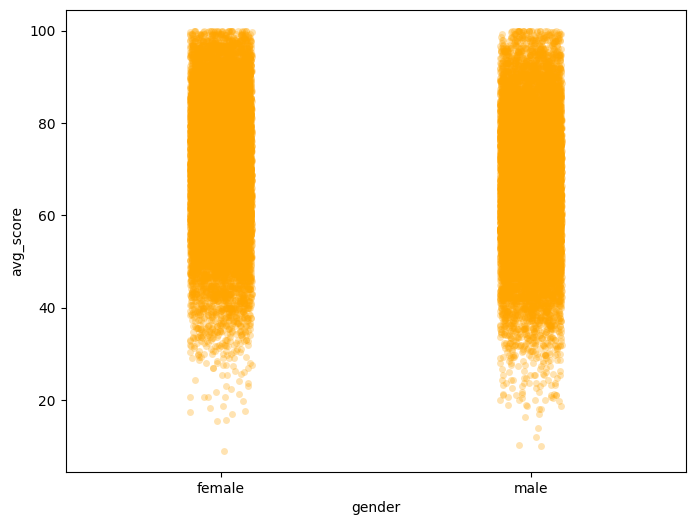

In [102]:
plt.figure(figsize=(8,6))
sns.stripplot(data=df, y='avg_score', x='gender', alpha=0.3, color='orange')
plt.show()

The plot above compares female vs male average scores. Female students have a higher concentration towards higher scores, while male students have more outliers on the lower end of scores. 

Through this notebook, the basic descriptive statistics of the data have been explored and documented. The relationships between certain metrics such as gender, lunch type, and test prep have been compared against scores. The actions taken in this notebook are part of exploring the data, and clear conclusions cannot be drawn from this basic analysis. In the next notebook, the relationships between demographics and scores will be explored in more detail. 

In [103]:
# saving the cleaned DataFrame to a new CSV file
df.to_csv('ExpandedScoresData_Cleaned.csv', index=False)